In [9]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT, Hodograph
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Import functions from process_radiosondes.py
import importlib
import process_radiosondes
importlib.reload(process_radiosondes)
from process_radiosondes import read_rs41_bufr, wind_components

In [31]:
# Install cartopy for map plotting
!pip install cartopy

In [6]:
# Install required packages
!pip install eccodes cffi metpy

In [2]:
def plot_skewt_with_hodograph(profiles):
    """
    Plot Skew-T diagram with hodograph as a subplot
    """
    # Create figure
    fig = plt.figure(figsize=(16, 10))
    
    # Create Skew-T on the left side - use rect parameter for proper positioning
    skew = SkewT(fig, rotation=45, rect=(0.07, 0.1, 0.55, 0.8))
    
    # Plot Skew-T data
    for i, profile in enumerate(profiles):
        # Filter out NaN values
        mask = ~(np.isnan(profile['temperature']) | np.isnan(profile['pressure']) | np.isnan(profile['dewpoint']))
        
        if np.sum(mask) > 0:
            p = profile['pressure'][mask] * units.hPa
            T = profile['temperature'][mask] * units.degC
            Td = profile['dewpoint'][mask] * units.degC
            
            # Plot temperature and dewpoint with colorblind-friendly colors
            # Using dark blue for temperature and orange for dewpoint
            skew.plot(p, T, color='#0173B2', linewidth=2.5, label=f"Temperature")
            skew.plot(p, Td, color='#DE8F05', linewidth=2.5, label=f"Dewpoint")
            
            # Plot wind barbs if available
            wind_mask = ~(np.isnan(profile['wind_speed']) | np.isnan(profile['wind_direction']) | np.isnan(profile['pressure']))
            if np.sum(wind_mask) > 10:
                # Subsample wind data for cleaner display
                wind_subsample = wind_mask.copy()
                indices = np.where(wind_mask)[0]
                keep_indices = indices[::40]
                wind_subsample[:] = False
                wind_subsample[keep_indices] = True
                
                p_wind = profile['pressure'][wind_subsample] * units.hPa
                u, v = wind_components(profile['wind_speed'][wind_subsample], 
                                      profile['wind_direction'][wind_subsample])
                skew.plot_barbs(p_wind, u * units('m/s'), v * units('m/s'))
    
    # Add the relevant special lines with adjusted colors
    skew.plot_dry_adiabats(alpha=0.25, color='#CC78BC')  # Purple/magenta
    skew.plot_moist_adiabats(alpha=0.25, color='#029E73')  # Teal/cyan
    skew.plot_mixing_lines(alpha=0.25, color='#949494')  # Gray
    
    # Set axis limits
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 40)
    
    # Add labels
    skew.ax.set_xlabel('Temperature (°C)', fontsize=12)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=12)
    skew.ax.legend(loc='upper left', fontsize=10)
    
    # Create hodograph on the right
    hodo_ax = fig.add_axes([0.70, 0.1, 0.25, 0.8])
    h = Hodograph(hodo_ax, component_range=60)
    h.add_grid(increment=10)
    
    for i, profile in enumerate(profiles):
        # Filter wind data
        wind_mask = ~(np.isnan(profile['wind_speed']) | np.isnan(profile['wind_direction']) | np.isnan(profile['height']))
        
        if np.sum(wind_mask) > 10:
            u, v = wind_components(profile['wind_speed'][wind_mask], 
                                  profile['wind_direction'][wind_mask])
            heights = profile['height'][wind_mask]
            
            # Convert to units
            u = u * units('m/s')
            v = v * units('m/s')
            
            # Color code by height
            colors = plt.cm.rainbow(np.linspace(0, 1, len(u)))
            
            # Plot hodograph with color gradient
            for j in range(len(u) - 1):
                h.ax.plot([u[j].magnitude, u[j+1].magnitude], 
                         [v[j].magnitude, v[j+1].magnitude], 
                         color=colors[j], linewidth=2, alpha=0.7)
            
            # Add markers at specific heights
            height_markers = [0, 1000, 3000, 6000, 9000, 12000]
            for hm in height_markers:
                idx = np.argmin(np.abs(heights - hm))
                if np.abs(heights[idx] - hm) < 500:
                    h.ax.plot(u[idx].magnitude, v[idx].magnitude, 'ko', markersize=6)
                    h.ax.text(u[idx].magnitude + 1.5, v[idx].magnitude + 1.5, 
                            f'{int(heights[idx]/1000)}km', 
                            fontsize=8, fontweight='bold')
    
    hodo_ax.set_title('Hodograph', fontsize=12, fontweight='bold', pad=10)
    
    # Add colorbar for height to the right of hodograph, matching its vertical size
    sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, 
                               norm=plt.Normalize(vmin=0, vmax=max(profile['height'][wind_mask])/1000))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=hodo_ax, pad=0.08, fraction=0.046, aspect=20)
    cbar.set_label('Height (km)', fontsize=11)
    
    # Add overall title
    timestamp = profiles[0]['timestamp'] if profiles and profiles[0]['timestamp'] else ''
    lat = profiles[0]['latitude'] if profiles and profiles[0]['latitude'] else ''
    lon = profiles[0]['longitude'] if profiles and profiles[0]['longitude'] else ''
    fig.suptitle(f'RS41-SGP Radiosonde: {timestamp}  (Lat: {lat:.2f}°, Lon: {lon:.2f}°)', 
                fontsize=14, fontweight='bold', y=0.98)
    
    return fig


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_hodograph_on_map(profiles):
    """
    Plot wind vectors overlaid on a map showing the balloon's drift trajectory
    """
    if not profiles or len(profiles) == 0:
        print("No profiles to plot")
        return None
    
    profile = profiles[0]
    lat = profile['latitude']
    lon = profile['longitude']
    
    # Filter wind data
    wind_mask = ~(np.isnan(profile['wind_speed']) | np.isnan(profile['wind_direction']) | np.isnan(profile['height']))
    
    if np.sum(wind_mask) < 10:
        print("Not enough wind data")
        return None
    
    u, v = wind_components(profile['wind_speed'][wind_mask], 
                          profile['wind_direction'][wind_mask])
    heights = profile['height'][wind_mask]
    
    # Calculate cumulative drift from launch point
    ascent_rate = 5.0  # m/s
    dt = np.diff(heights) / ascent_rate
    dt = np.concatenate([[0], dt])
    
    # Calculate cumulative displacement in meters
    cumulative_u = np.cumsum(u * dt)
    cumulative_v = np.cumsum(v * dt)
    
    # Convert displacement to lat/lon offsets
    meters_per_deg_lat = 111000
    meters_per_deg_lon = 111000 * np.cos(np.radians(lat))
    
    drift_lons = lon + cumulative_u / meters_per_deg_lon
    drift_lats = lat + cumulative_v / meters_per_deg_lat
    
    # Create figure with better styling
    fig = plt.figure(figsize=(16, 12), facecolor='white')
    
    # Calculate map extent
    lon_padding = max(0.3, (drift_lons.max() - drift_lons.min()) * 0.2)
    lat_padding = max(0.3, (drift_lats.max() - drift_lats.min()) * 0.2)
    lon_min = min(drift_lons.min(), lon) - lon_padding
    lon_max = max(drift_lons.max(), lon) + lon_padding
    lat_min = min(drift_lats.min(), lat) - lat_padding
    lat_max = max(drift_lats.max(), lat) + lat_padding
    map_extent = [lon_min, lon_max, lat_min, lat_max]
    
    # Create map axis
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent(map_extent, crs=ccrs.PlateCarree())
    ax.set_facecolor('#f0f0f0')
    
    # Add map features with better styling
    ax.add_feature(cfeature.LAND, facecolor='#e8e8e8', edgecolor='none', zorder=1)
    ax.add_feature(cfeature.OCEAN, facecolor='#d4e7f5', edgecolor='none', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, edgecolor='#666666', zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.8, linestyle='--', edgecolor='#999999', zorder=2)
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', 
                      alpha=0.4, linestyle=':', zorder=2)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 11}
    gl.ylabel_style = {'size': 11}
    
    # Plot smooth trajectory line
    ax.plot(drift_lons, drift_lats, 
           color='#555555', linewidth=4, alpha=0.3,
           transform=ccrs.PlateCarree(), zorder=3,
           solid_capstyle='round')
    
    # Overlay with colored gradient
    colors = plt.cm.plasma(np.linspace(0, 1, len(drift_lons)))
    for j in range(len(drift_lons) - 1):
        ax.plot([drift_lons[j], drift_lons[j+1]], 
               [drift_lats[j], drift_lats[j+1]], 
               color=colors[j], linewidth=3.5, alpha=0.9,
               transform=ccrs.PlateCarree(), zorder=4,
               solid_capstyle='round')
    
    # Mark the launch location
    ax.plot(lon, lat, marker='*', color='#ff3333', markersize=30, 
            transform=ccrs.PlateCarree(), zorder=10, 
            markeredgecolor='white', markeredgewidth=2,
            label='Launch Site')
    
    # Add altitude markers at key heights
    height_markers = [0, 3000, 6000, 9000, 12000, 15000]
    for hm in height_markers:
        idx = np.argmin(np.abs(heights - hm))
        if idx < len(drift_lons) and np.abs(heights[idx] - hm) < 800:
            # Plot marker point
            ax.plot(drift_lons[idx], drift_lats[idx], 'o', 
                   color=colors[idx], markersize=12,
                   markeredgecolor='white', markeredgewidth=2,
                   transform=ccrs.PlateCarree(), zorder=8)
            
            # Add label with background
            ax.text(drift_lons[idx], drift_lats[idx], 
                   f'  {int(heights[idx]/1000)}km  ', 
                   fontsize=11, fontweight='bold',
                   ha='left', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.4', 
                            facecolor='white', 
                            edgecolor=colors[idx],
                            linewidth=2,
                            alpha=0.95),
                   transform=ccrs.PlateCarree(), zorder=9)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                               norm=plt.Normalize(vmin=0, vmax=max(heights)/1000))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02, fraction=0.04, aspect=25, shrink=0.8)
    cbar.set_label('Altitude (km)', fontsize=13, fontweight='bold')
    cbar.ax.tick_params(labelsize=11)
    
    # Calculate and display drift statistics
    total_drift = np.sqrt((drift_lons[-1] - lon)**2 + (drift_lats[-1] - lat)**2) * 111
    max_height = max(heights) / 1000
    
    # Add title
    timestamp = profile['timestamp'] if profile['timestamp'] else ''
    fig.suptitle(f'Radiosonde Wind Trajectory: {timestamp}', 
                fontsize=16, fontweight='bold', y=0.97)
    
    # Add subtitle with info
    ax.text(0.5, 1.02, 
           f'Launch: {lat:.3f}°N, {lon:.3f}°E  |  ' +
           f'Total Drift: {total_drift:.1f} km  |  ' +
           f'Max Altitude: {max_height:.1f} km',
           transform=ax.transAxes,
           fontsize=12, ha='center', style='italic',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    ax.legend(loc='upper left', fontsize=12, framealpha=0.95, 
             edgecolor='gray', fancybox=True, shadow=True)
    
    plt.tight_layout()
    
    return fig

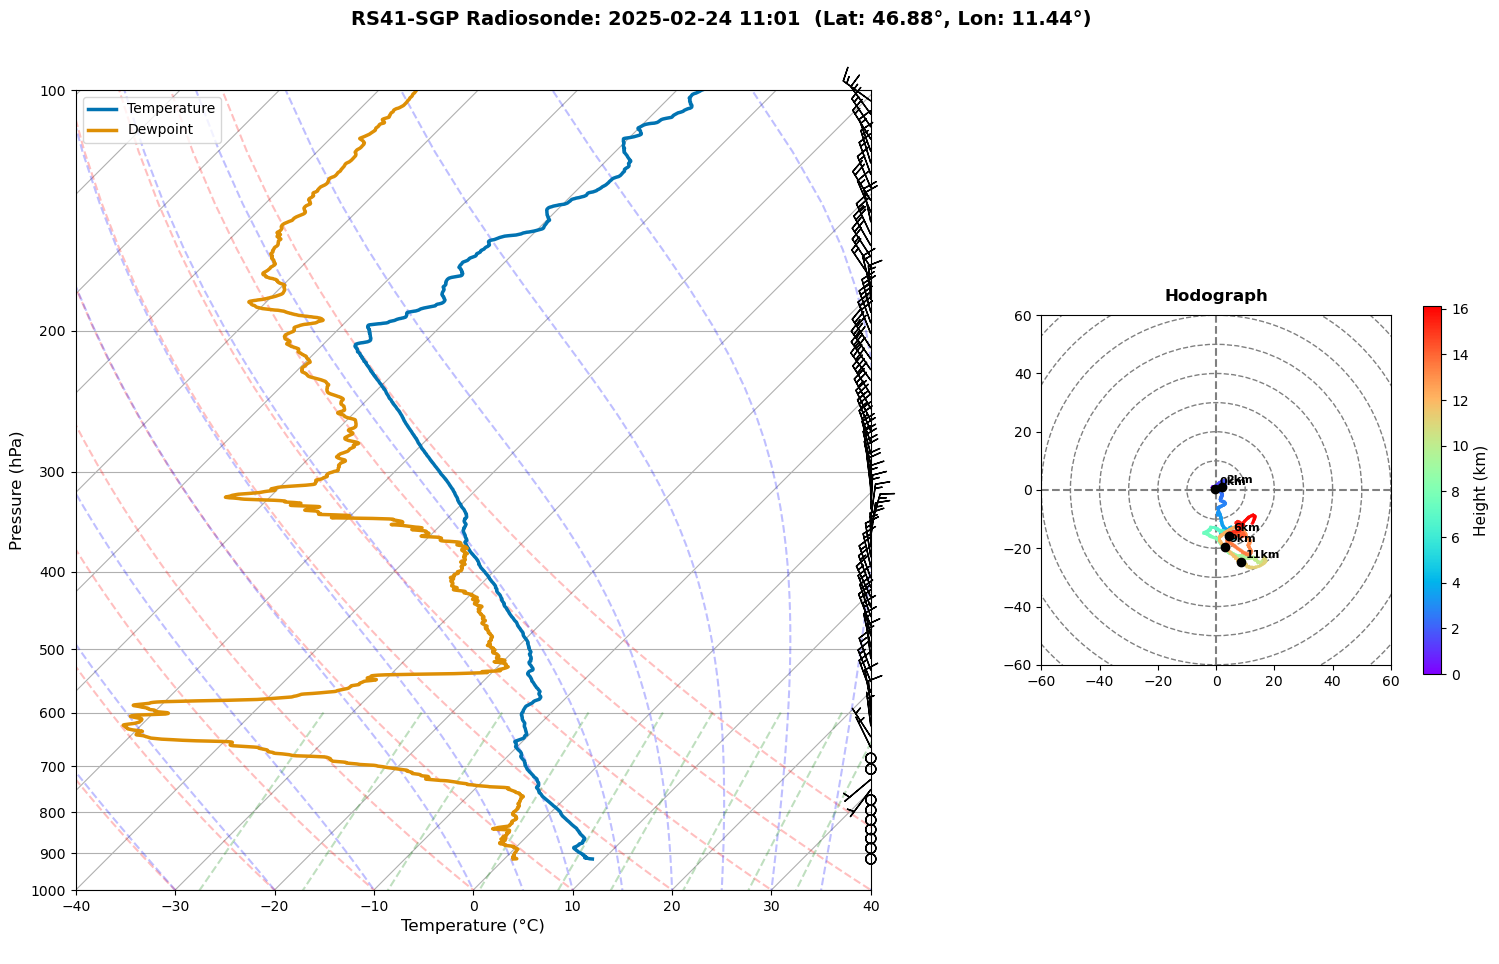

In [10]:
data = read_rs41_bufr('/gws/pw/j07/ncas_obs_vol1/amf/raw_data/ncas-radiosonde-2/incoming/teamx/bufr_files/bufr309052_all_20250224_1101_0.bfr')
plot_skewt_with_hodograph(data);

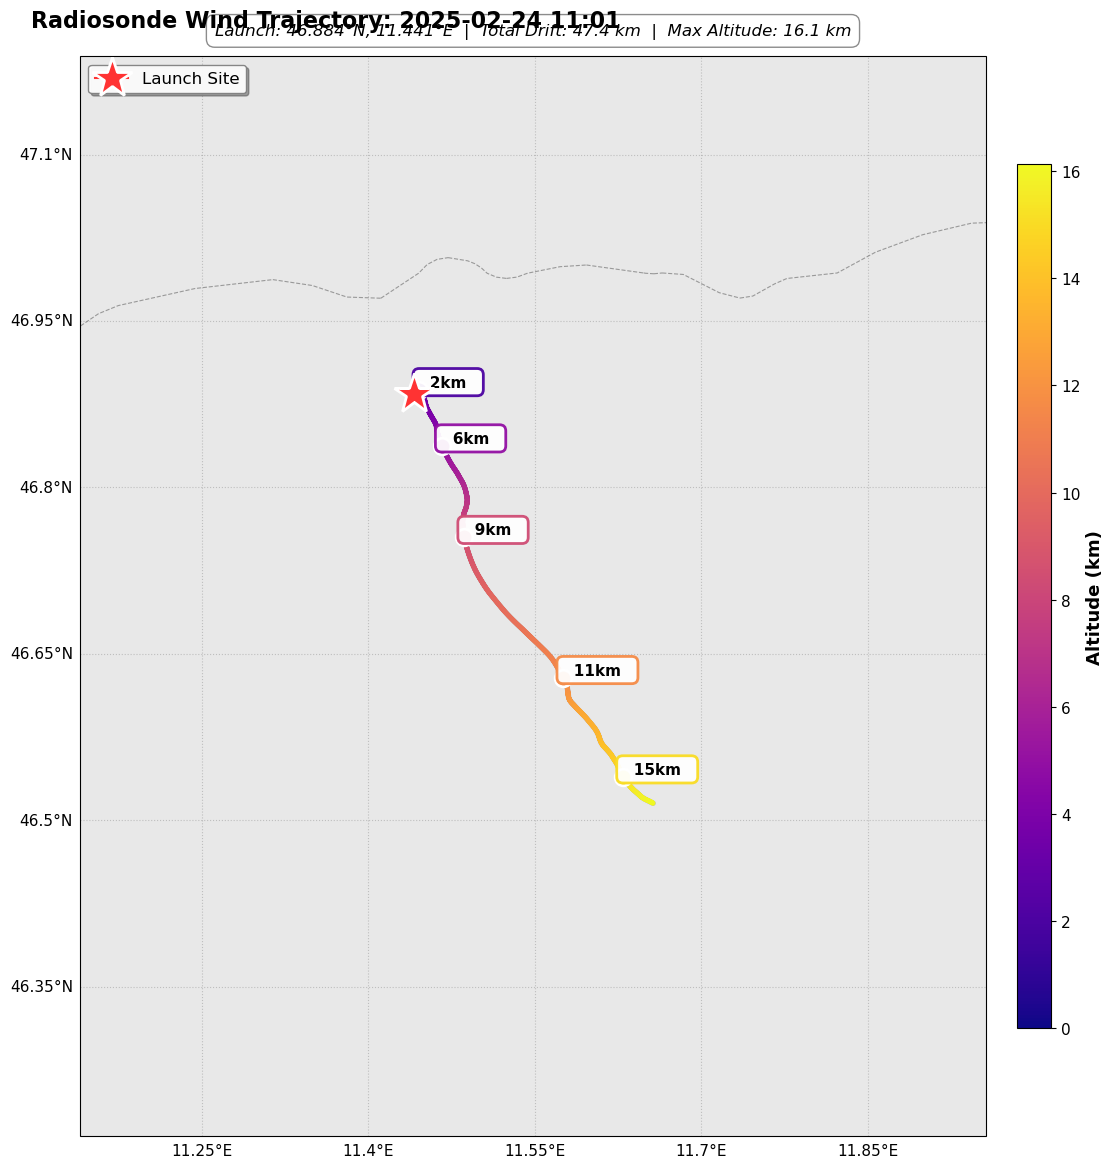

In [41]:
# Plot hodograph on map
plot_hodograph_on_map(data);

In [ ]:
def plot_combined_analysis(profiles):
    """
    Combined plot: Skew-T on left, hodograph and map stacked on right
    """
    if not profiles or len(profiles) == 0:
        print("No profiles to plot")
        return None
    
    profile = profiles[0]
    lat = profile['latitude']
    lon = profile['longitude']
    
    # Create figure
    fig = plt.figure(figsize=(20, 12))
    
    # ============ SKEW-T (Left side) ============
    # Use rect parameter for proper skew projection - (left, bottom, width, height)
    skew = SkewT(fig, rotation=45, rect=(0.06, 0.06, 0.42, 0.87))
    
    # Plot Skew-T data
    for i, prof in enumerate(profiles):
        mask = ~(np.isnan(prof['temperature']) | np.isnan(prof['pressure']) | np.isnan(prof['dewpoint']))
        
        if np.sum(mask) > 0:
            p = prof['pressure'][mask] * units.hPa
            T = prof['temperature'][mask] * units.degC
            Td = prof['dewpoint'][mask] * units.degC
            
            skew.plot(p, T, color='#0173B2', linewidth=2.5, label="Temperature")
            skew.plot(p, Td, color='#DE8F05', linewidth=2.5, label="Dewpoint")
            
            # Wind barbs
            wind_mask = ~(np.isnan(prof['wind_speed']) | np.isnan(prof['wind_direction']) | np.isnan(prof['pressure']))
            if np.sum(wind_mask) > 10:
                wind_subsample = wind_mask.copy()
                indices = np.where(wind_mask)[0]
                keep_indices = indices[::40]
                wind_subsample[:] = False
                wind_subsample[keep_indices] = True
                
                p_wind = prof['pressure'][wind_subsample] * units.hPa
                u, v = wind_components(prof['wind_speed'][wind_subsample], 
                                      prof['wind_direction'][wind_subsample])
                skew.plot_barbs(p_wind, u * units('m/s'), v * units('m/s'))
    
    skew.plot_dry_adiabats(alpha=0.25, color='#CC78BC')
    skew.plot_moist_adiabats(alpha=0.25, color='#029E73')
    skew.plot_mixing_lines(alpha=0.25, color='#949494')
    
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 40)
    skew.ax.set_xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=12, fontweight='bold')
    skew.ax.set_title('Skew-T Log-P Diagram', fontsize=13, fontweight='bold', pad=10)
    skew.ax.legend(loc='upper left', fontsize=11)
    
    # ============ HODOGRAPH (Top right) ============
    hodo_ax = fig.add_axes([0.55, 0.52, 0.40, 0.40])
    h = Hodograph(hodo_ax, component_range=60)
    h.add_grid(increment=10)
    
    wind_mask = ~(np.isnan(profile['wind_speed']) | np.isnan(profile['wind_direction']) | np.isnan(profile['height']))
    
    if np.sum(wind_mask) > 10:
        u, v = wind_components(profile['wind_speed'][wind_mask], 
                              profile['wind_direction'][wind_mask])
        heights = profile['height'][wind_mask]
        
        u = u * units('m/s')
        v = v * units('m/s')
        
        # Color gradient
        colors = plt.cm.rainbow(np.linspace(0, 1, len(u)))
        for j in range(len(u) - 1):
            h.ax.plot([u[j].magnitude, u[j+1].magnitude], 
                     [v[j].magnitude, v[j+1].magnitude], 
                     color=colors[j], linewidth=2.5, alpha=0.8)
        
        # Height markers
        height_markers = [0, 1000, 3000, 6000, 9000, 12000]
        for hm in height_markers:
            idx = np.argmin(np.abs(heights - hm))
            if np.abs(heights[idx] - hm) < 500:
                h.ax.plot(u[idx].magnitude, v[idx].magnitude, 'ko', markersize=7)
                h.ax.text(u[idx].magnitude + 1.5, v[idx].magnitude + 1.5, 
                        f'{int(heights[idx]/1000)}km', 
                        fontsize=9, fontweight='bold')
        
        # Colorbar
        sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, 
                                   norm=plt.Normalize(vmin=0, vmax=max(heights)/1000))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=hodo_ax, pad=0.05, fraction=0.046, aspect=15)
        cbar.set_label('Height (km)', fontsize=11, fontweight='bold')
    
    hodo_ax.set_title('Hodograph', fontsize=13, fontweight='bold', pad=10)
    
    # ============ MAP (Bottom right) ============
    if np.sum(wind_mask) < 10:
        print("Not enough wind data for map")
        return fig
    
    u_vals, v_vals = wind_components(profile['wind_speed'][wind_mask], 
                                     profile['wind_direction'][wind_mask])
    heights = profile['height'][wind_mask]
    
    # Calculate drift trajectory
    ascent_rate = 5.0
    dt = np.diff(heights) / ascent_rate
    dt = np.concatenate([[0], dt])
    
    cumulative_u = np.cumsum(u_vals * dt)
    cumulative_v = np.cumsum(v_vals * dt)
    
    meters_per_deg_lat = 111000
    meters_per_deg_lon = 111000 * np.cos(np.radians(lat))
    
    drift_lons = lon + cumulative_u / meters_per_deg_lon
    drift_lats = lat + cumulative_v / meters_per_deg_lat
    
    # Map extent
    lon_padding = max(0.3, (drift_lons.max() - drift_lons.min()) * 0.2)
    lat_padding = max(0.3, (drift_lats.max() - drift_lats.min()) * 0.2)
    lon_min = min(drift_lons.min(), lon) - lon_padding
    lon_max = max(drift_lons.max(), lon) + lon_padding
    lat_min = min(drift_lats.min(), lat) - lat_padding
    lat_max = max(drift_lats.max(), lat) + lat_padding
    map_extent = [lon_min, lon_max, lat_min, lat_max]
    
    map_ax = fig.add_axes([0.55, 0.06, 0.40, 0.40], projection=ccrs.PlateCarree())
    map_ax.set_extent(map_extent, crs=ccrs.PlateCarree())
    map_ax.set_facecolor('#f0f0f0')
    
    # Map features
    map_ax.add_feature(cfeature.LAND, facecolor='#e8e8e8', edgecolor='none', zorder=1)
    map_ax.add_feature(cfeature.OCEAN, facecolor='#d4e7f5', edgecolor='none', zorder=1)
    map_ax.add_feature(cfeature.COASTLINE, linewidth=1.2, edgecolor='#666666', zorder=2)
    map_ax.add_feature(cfeature.BORDERS, linewidth=0.8, linestyle='--', edgecolor='#999999', zorder=2)
    
    # Gridlines
    gl = map_ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', 
                          alpha=0.4, linestyle=':', zorder=2)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    # Trajectory
    map_ax.plot(drift_lons, drift_lats, 
               color='#555555', linewidth=4, alpha=0.3,
               transform=ccrs.PlateCarree(), zorder=3,
               solid_capstyle='round')
    
    colors = plt.cm.plasma(np.linspace(0, 1, len(drift_lons)))
    for j in range(len(drift_lons) - 1):
        map_ax.plot([drift_lons[j], drift_lons[j+1]], 
                   [drift_lats[j], drift_lats[j+1]], 
                   color=colors[j], linewidth=3.5, alpha=0.9,
                   transform=ccrs.PlateCarree(), zorder=4,
                   solid_capstyle='round')
    
    # Launch site
    map_ax.plot(lon, lat, marker='*', color='#ff3333', markersize=25, 
                transform=ccrs.PlateCarree(), zorder=10, 
                markeredgecolor='white', markeredgewidth=2,
                label='Launch Site')
    
    # Altitude markers
    height_markers = [0, 3000, 6000, 9000, 12000, 15000]
    for hm in height_markers:
        idx = np.argmin(np.abs(heights - hm))
        if idx < len(drift_lons) and np.abs(heights[idx] - hm) < 800:
            map_ax.plot(drift_lons[idx], drift_lats[idx], 'o', 
                       color=colors[idx], markersize=10,
                       markeredgecolor='white', markeredgewidth=2,
                       transform=ccrs.PlateCarree(), zorder=8)
            
            map_ax.text(drift_lons[idx], drift_lats[idx], 
                       f'  {int(heights[idx]/1000)}km  ', 
                       fontsize=10, fontweight='bold',
                       ha='left', va='bottom',
                       bbox=dict(boxstyle='round,pad=0.3', 
                                facecolor='white', 
                                edgecolor=colors[idx],
                                linewidth=1.5,
                                alpha=0.95),
                       transform=ccrs.PlateCarree(), zorder=9)
    
    # Colorbar for map
    sm_map = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                                   norm=plt.Normalize(vmin=0, vmax=max(heights)/1000))
    sm_map.set_array([])
    cbar_map = plt.colorbar(sm_map, ax=map_ax, pad=0.02, fraction=0.046, aspect=15)
    cbar_map.set_label('Altitude (km)', fontsize=11, fontweight='bold')
    
    # Calculate drift
    total_drift = np.sqrt((drift_lons[-1] - lon)**2 + (drift_lats[-1] - lat)**2) * 111
    
    map_ax.set_title(f'Wind Trajectory (Total Drift: {total_drift:.1f} km)', 
                     fontsize=13, fontweight='bold', pad=10)
    map_ax.legend(loc='upper left', fontsize=10, framealpha=0.95, 
                 edgecolor='gray', fancybox=True)
    
    # Overall title
    timestamp = profile['timestamp'] if profile['timestamp'] else ''
    fig.suptitle(f'RS41-SGP Radiosonde Analysis: {timestamp}  ' +
                f'(Launch: {lat:.3f}°N, {lon:.3f}°E)', 
                fontsize=16, fontweight='bold')
    
    return fig

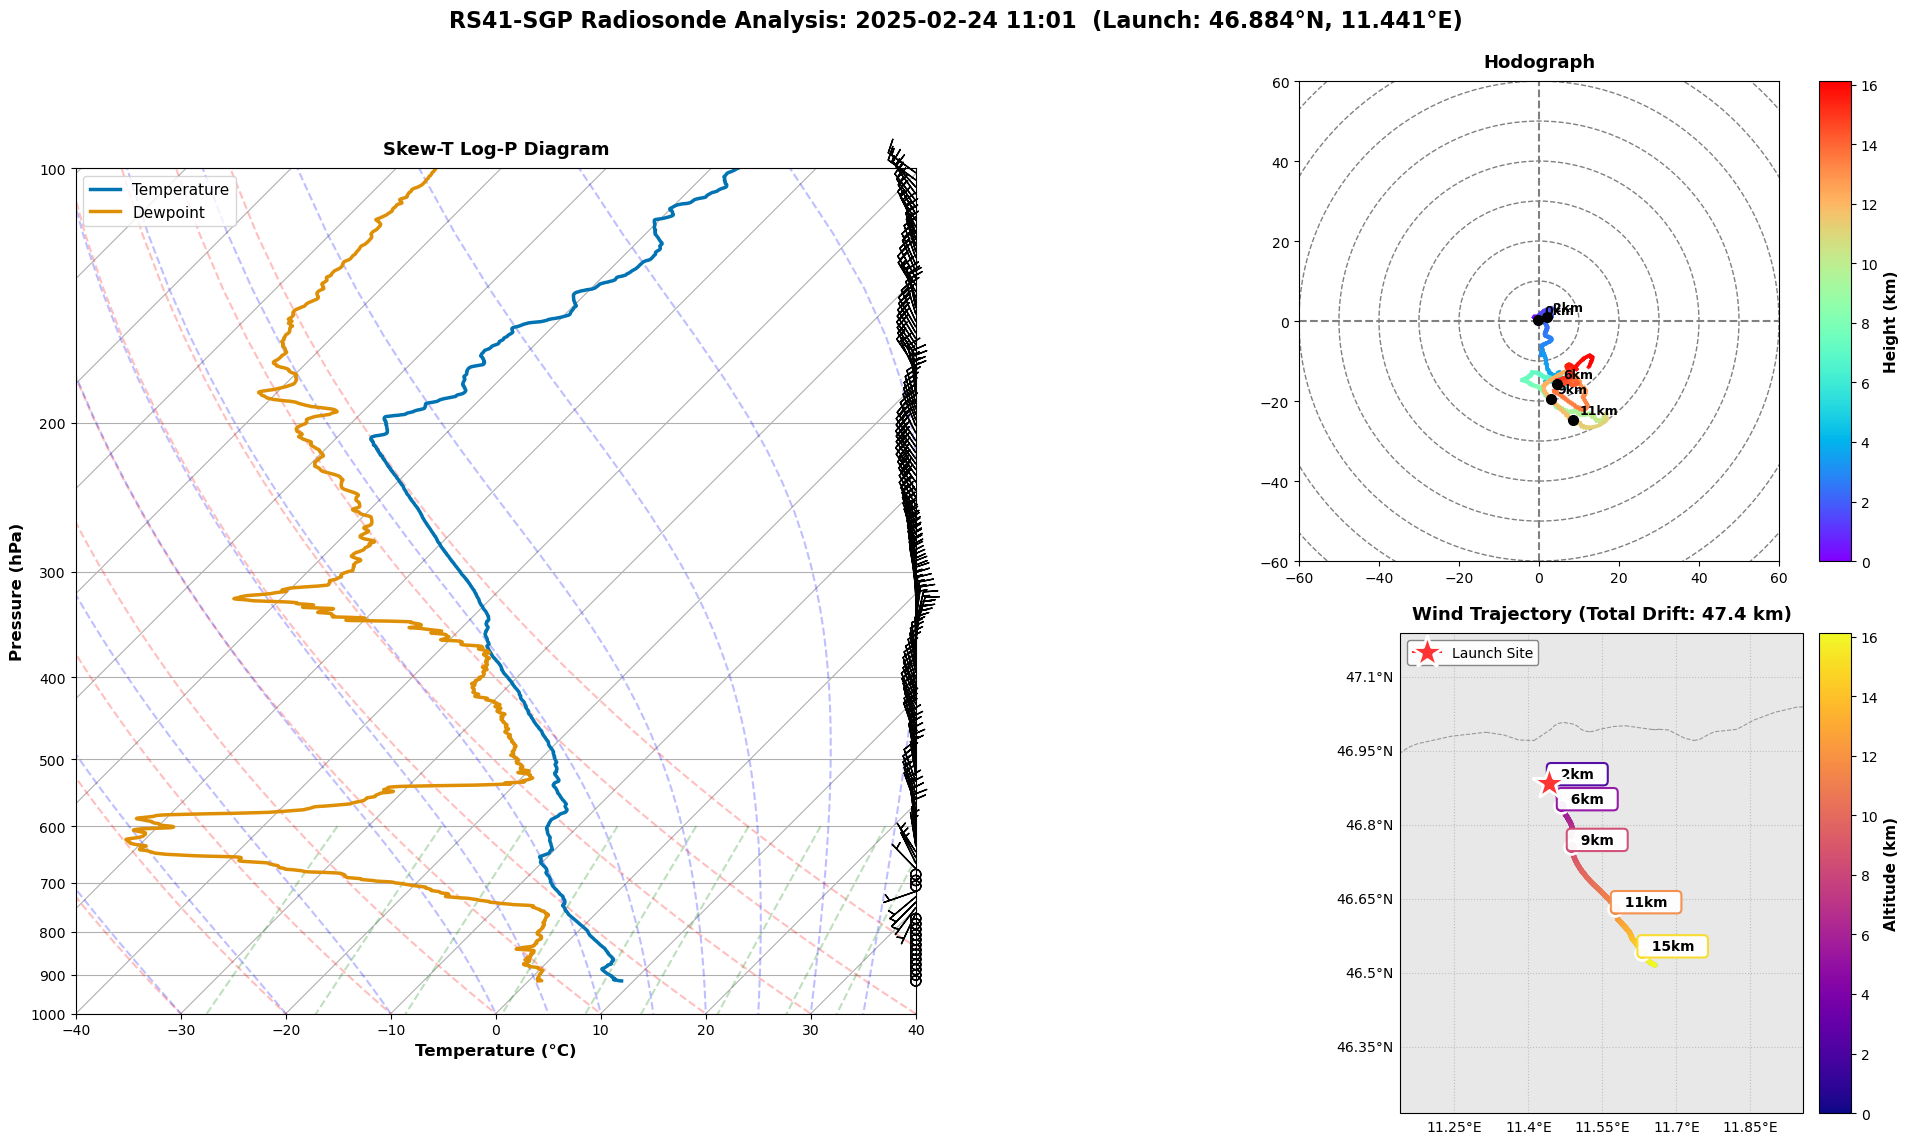

In [45]:
# Combined analysis: Skew-T on left, hodograph and map stacked on right
plot_combined_analysis(data);